In [28]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.linear_model import OLS



OPPGAVE A)

In [29]:

# Når det kommer til scraping, har jeg her 
# valgt å bruke metode fra notebooks kap.9 av Espen S.

def fetch_html_tables(url):
    "Returnerer en liste av tabellene i html'en av url"
    page = requests.get(url)
    bs=BeautifulSoup(page.content)
    tables=bs.find_all('table')
    return tables

tables=fetch_html_tables('https://countrymeters.info/en/World')
table_html=tables[5] #Her valgte jeg den ønskede tabellen fra siden

print(str(table_html)[:1000])

<table class="years">
<th>Religion</th>
<th>Number of followers</th>
<th>Percentage of <br/>total population</th>
<tr><td>Christianity</td><td>2,516,609,196</td><td>31.7 %</td></tr><tr><td>Islam</td><td>1,976,694,115</td><td>24.9 %</td></tr><tr><td>Religiously Unaffiliated</td><td>1,214,708,370</td><td>15.3 %</td></tr><tr><td>Hinduism</td><td>1,183,523,834</td><td>14.9 %</td></tr><tr><td>Buddhism</td><td>525,985,785</td><td>6.6 %</td></tr><tr><td>Folk or traditional religions</td><td>448,142,399</td><td>5.6 %</td></tr><tr><td>Other</td><td>67,365,837</td><td>0.8 %</td></tr><tr><td>Judaism</td><td>15,088,985</td><td>0.2 %</td></tr>
</table>


In [30]:
def html_to_table(html):
    "Returnerer tabellen definert i html som en list"
    #definerer "table":
    table=[]
    #iterasjon av alle "rows"
    for row in html.find_all('tr'):
        r=[]
        #finner alle cellene i hver "row":
        cells=row.find_all('td')
        
        #Om ingen celler blir funnet, se etter "headings"
        if len(cells)==0:
            cells=row.find_all('th')
            
        #iterasjon av celler:
        for cell in cells:
            cell=format(cell)
            r.append(cell)
        
        #(append) legge til "row" til table:
        table.append(r)
    return table

def format(cell):
    "Returnerer en string etter konvertering  av bs4 object cell til ren text"
    if cell.content is None:
        s=cell.text
    elif len(cell.content)==0:
        return ''
    else:
        s=' '.join([str(c) for c in cell.content])
        
    #I tillegg til ting som allerede skulle fjernes 
    # i denne funksjonen, la jeg til noen flere. 
    
    s=s.replace('\xa0','')
    s=s.replace('\n','')
    s=s.replace('%','')
    s=s.replace(",","")
    return s

table=html_to_table(table_html)

print(str(table)[:1000])

[['Christianity', '2516609196', '31.7 '], ['Islam', '1976694115', '24.9 '], ['Religiously Unaffiliated', '1214708370', '15.3 '], ['Hinduism', '1183523834', '14.9 '], ['Buddhism', '525985785', '6.6 '], ['Folk or traditional religions', '448142399', '5.6 '], ['Other', '67365837', '0.8 '], ['Judaism', '15088985', '0.2 ']]


In [31]:

#Her lagrer jeg data gjennom en funksjon hentet fra notebooks kap.9

def save_data(file_name,table):
    "Saves table to file_name"
    f=open(file_name,'w')
    for row in table:
        f.write(';'.join(row)+'\n')
    f.close()
    
save_data('FolkogReligion.csv',table)

In [32]:

#Bruker pandas til å lese csv, legger til delimiter, encoding og header.

FolkogReligion=pd.read_csv('FolkogReligion.csv', delimiter=';', encoding='latin1', header = None)
FolkogReligion = pd.DataFrame(FolkogReligion)
FolkogReligion

,0,1,2
0,Christianity,2516609196,31.7
1,Islam,1976694115,24.9
2,Religiously Unaffiliated,1214708370,15.3
3,Hinduism,1183523834,14.9
4,Buddhism,525985785,6.6
5,Folk or traditional religions,448142399,5.6
6,Other,67365837,0.8
7,Judaism,15088985,0.2


In [33]:

#Gir ønsket navn til kolonnene

FolkogReligion.columns = ['Religion','AntallFølgere','TotAvPopulasjonPros']
FolkogReligion

,Religion,AntallFølgere,TotAvPopulasjonPros
0,Christianity,2516609196,31.7
1,Islam,1976694115,24.9
2,Religiously Unaffiliated,1214708370,15.3
3,Hinduism,1183523834,14.9
4,Buddhism,525985785,6.6
5,Folk or traditional religions,448142399,5.6
6,Other,67365837,0.8
7,Judaism,15088985,0.2


In [34]:

#Konverterer en kolonne til fra object til float med tanke på plot
#Sjekker dtypes

FolkogReligion['AntallFølgere'] = FolkogReligion['AntallFølgere'].astype(float)
FolkogReligion.dtypes

Religion                object
AntallFølgere          float64
TotAvPopulasjonPros    float64
dtype: object

In [35]:
FolkogReligion.head()

,Religion,AntallFølgere,TotAvPopulasjonPros
0,Christianity,2.516609e+09,31.7
1,Islam,1.976694e+09,24.9
2,Religiously Unaffiliated,1.214708e+09,15.3
3,Hinduism,1.183524e+09,14.9
4,Buddhism,5.259858e+08,6.6


In [36]:

#Inspirasjon for framgangsmåte til regresjonsplot er hentet fra
#notebooks kap.10

y=FolkogReligion['TotAvPopulasjonPros'] #Her lager jeg en df av ønsket y akse
pd.DataFrame(y)

,TotAvPopulasjonPros
0,31.7
1,24.9
2,15.3
3,14.9
4,6.6
5,5.6
6,0.8
7,0.2


In [37]:

#Så lager jeg df av ønsket x akse, og sørger for å bruke np.log()
#lager i tillegg en kolonne med "intercept",konstantledd på 1, etter oppskrift fra notebooks
#kap.10

x=pd.DataFrame(np.log(FolkogReligion['AntallFølgere']))
x['intercept']=1
x

,AntallFølgere,intercept
0,21.646178,1
1,21.404692,1
2,20.917770,1
3,20.891762,1
4,20.080785,1
5,19.920622,1
6,18.025649,1
7,16.529476,1


In [39]:

#Ved hjelp av statmodels.regression.linear_model samler jeg x og y for å
#estimere hvilke koeffisienter jeg har. 
#Oppsummerer regresjons resultatet

resultat=OLS(y,x).fit()

print(resultat.summary())

                             OLS Regression Results                            
Dep. Variable:     TotAvPopulasjonPros   R-squared:                       0.710
Model:                             OLS   Adj. R-squared:                  0.661
Method:                  Least Squares   F-statistic:                     14.66
Date:                 Sat, 02 Apr 2022   Prob (F-statistic):            0.00867
Time:                         11:10:44   Log-Likelihood:                -25.327
No. Observations:                    8   AIC:                             54.65
Df Residuals:                        6   BIC:                             54.81
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
AntallFølgere     5.3790      1.405 

/usr/local/Miniconda3-py39_4.10.3-Linux-x86_64/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Koeffisienter :
𝛼 = 5.378956
𝛽 = -94.687091 

Koeffisientene er lagret i resultat.params, så med dette kan jeg nå forsøke å plotte; 𝛼 + 𝛽 ⋅ 𝑥

In [128]:
resultat.params

AntallFølgere     5.378956
intercept       -94.687091
dtype: float64

In [129]:

#Her gjør jeg utregningen (XPlot), 
#lager Y og C i repektive YPlot og CPlot.

XPlot = resultat.params["intercept"]+resultat.params["AntallFølgere"] * np.log(FolkogReligion['AntallFølgere'])

YPlot = FolkogReligion['TotAvPopulasjonPros']

CPlot = FolkogReligion['Religion']

In [130]:

#Deretter bruker jeg pandas merge og samler X, Y og C til en df som
#kan plottes.
#on = Cplot, key.
ScatPlotReg1 = pd.merge(XPlot,YPlot, on = CPlot)
#Gav nytt navn fra key_0 til Religion
ScatPlotReg1.rename(columns = {'key_0':'Religion'}, inplace = True)

ScatPlotReg1

,Religion,AntallFølgere,TotAvPopulasjonPros
0,Christianity,21.746758,31.7
1,Islam,20.447812,24.9
2,Religiously Unaffiliated,17.828681,15.3
3,Hinduism,17.688786,14.9
4,Buddhism,13.326575,6.6
5,Folk or traditional religions,12.465064,5.6
6,Other,2.272087,0.8
7,Judaism,-5.775763,0.2


Text(0.5, 1.0, 'Regresjon Plot\nReligionstilhørighet blandt Verdens befolkning')

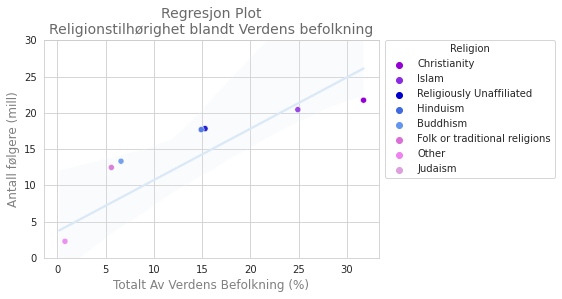

In [131]:
#Plottet valgte jeg å gjøre med seaborn.
sns.set_style("whitegrid") #setter en theme
sns.set_palette(sns.color_palette("Blues"))#farge på regresjonslinja
palett = {'Christianity': 'darkviolet',#valgte farger selv til Religioner
          'Islam': 'blueviolet',
          'Religiously Unaffiliated': 'mediumblue',
          'Hinduism': 'royalblue',
          'Buddhism': 'cornflowerblue',
          'Folk or traditional religions': 'orchid',
          'Other': 'violet',
          'Judaism': 'plum'}
#Første del av plottet, scatterplot der jeg inkluderte hue = palett
ax = sns.scatterplot(data=ScatPlotReg1, 
                     x="TotAvPopulasjonPros", 
                     y="AntallFølgere",
                     hue="Religion",
                     palette = palett)
#Andre del av plottet, regresjonslinje.
g = sns.regplot(data=ScatPlotReg1,
              x="TotAvPopulasjonPros", 
              y="AntallFølgere", 
              scatter=False,ax=ax) 
g.legend(bbox_to_anchor=(1.02, 1),#plassering av legend
               loc='upper left',
               title = "Religion",
               borderaxespad=0)
g.set(ylim=(0, 30))#satt ylim ned fra 0-45 til 0-30
g.set_xlabel("Totalt Av Verdens Befolkning (%)", #Titler til plott og akser
             fontsize = 12, color = "gray")
g.set_ylabel("Antall følgere (mill)", 
             fontsize = 12, color = "gray")
g.set_title("Regresjon Plot\nReligionstilhørighet blandt Verdens befolkning", 
               fontsize = 14, color = "dimgray")



Når tabellen omsider var på plass, ville jeg se på forholdet mellom Antall følgere av en religion mot verdens befolkning (%). 
Beskrivelse av framgangsmåte håper jeg ble lagt merke til underveis i kodingen.
Når jeg ser på grafen, har den en stigende regresjonslinje. Den estimerer en linær gjennomsnittlig linje gjennom punktene. Jo høyere antall følgere, jo større prosent av befolkningen er medlem av den respektive religionsgruppen. 
En rask tolkning er for eksempel at av verdens befolkning er det mest sansynlig at du tilhører kristen tro. 
En kan anta at ved å se på plasseringene av punktene rundt regresjonslinja er det ingen forhold som tilsier at det er gitt at du vil tilhøre en kristen tro, og av dette er det nærliggende å anta at hvordan religion en er følgere av, er tilfeldig. 
Vil også nevne at av verdens befolkning er det en trend i at mennesker velger å følge en religion da bare omlag 15% er religøs uavhengig. 
En avgjørende og vesentlig variabel som ville endret denne grafen er hvor en er født, og hvilke religioner er mest "populære" i dette området.